In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
import numpy as np
sys.path.append("../")

In [3]:
from RNN_utils import window_transform_text, encode_io_pairs, get_deep_rnn
from fnn_helper import PlotLosses

Using TensorFlow backend.


In [4]:
input_text = open('bodas_de_sangre.txt').read()
number_of_chars = len(input_text)
# Sumo el $ que es el end of sentence
all_chars = sorted(set(input_text + '$'))
print('Cantidad de caracteres: ' + str(number_of_chars))
print('Cantidad de caracteres unicos: ' + str(len(all_chars)))
print(all_chars)
print('------------------------------------------------------')
print(input_text[:1000])

Cantidad de caracteres: 67561
Cantidad de caracteres unicos: 72
['\n', ' ', '!', '$', '(', ')', ',', '.', '1', '2', '3', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', '¡', '¿', 'É', 'Ñ', 'á', 'é', 'í', 'ñ', 'ó', 'ú']
------------------------------------------------------
BODAS DE SANGRE(1933)

Poema trágico en tres actos y siete cuadros

Personajes
 
Madre
Criada
Leonardo
Mozos
Novia
Vecina
Novio
Leñadores
Suegra
Muchachas
Padre de la novia
Mozos
Mujer de Leonardo
Luna
Muerte (como mendiga)

Acto primero

CUADRO PRIMERO

Habitación pintada de amarillo.

NOVIO: (Entrando) Madre.

MADRE: ¿Que?

NOVIO:Me voy.

MADRE: ¿Adónde?

NOVIO:A la viña. (Va a salir)

MADRE: Espera.

NOVIO:¿Quieres algo?

MADRE: Hijo, el almuerzo.

NOVIO: Déjalo. Comeré uvas. Dame la navaja.

MADRE: ¿Para qué?


In [5]:
input_as_array = np.array(input_text.split('\n\n'))

In [6]:
input_data = []
output_data = []
for i, to_join in enumerate(input_as_array[::10]):
    joined = '\n\n'.join(input_as_array[i*10: i*10+10])
    input_data.append(joined)
    output_data.append(joined[1:] + '$')

In [7]:
input_data[1]

'NOVIO:A la viña. (Va a salir)\n\nMADRE: Espera.\n\nNOVIO:¿Quieres algo?\n\nMADRE: Hijo, el almuerzo.\n\nNOVIO: Déjalo. Comeré uvas. Dame la navaja.\n\nMADRE: ¿Para qué?\n\nNOVIO: (Riendo) Para cortarlas.\n\nMADRE: (Entre dientes y buscándola) La navaja, la navaja... Malditas sean todas y el bribón que las inventó.\n\nNOVIO: Vamos a otro asunto.\n\nMADRE: Y las escopetas, y las pistolas, y el cuchillo más pequeño, y hasta las azadas y los bieldos de la era.'

In [8]:
output_data[1]

'OVIO:A la viña. (Va a salir)\n\nMADRE: Espera.\n\nNOVIO:¿Quieres algo?\n\nMADRE: Hijo, el almuerzo.\n\nNOVIO: Déjalo. Comeré uvas. Dame la navaja.\n\nMADRE: ¿Para qué?\n\nNOVIO: (Riendo) Para cortarlas.\n\nMADRE: (Entre dientes y buscándola) La navaja, la navaja... Malditas sean todas y el bribón que las inventó.\n\nNOVIO: Vamos a otro asunto.\n\nMADRE: Y las escopetas, y las pistolas, y el cuchillo más pequeño, y hasta las azadas y los bieldos de la era.$'

In [9]:
lens = []
for in_dat in input_data:
    lens.append(len(in_dat))

In [10]:
max_len = np.max(lens)
print(max_len)

3728


In [11]:
chars_to_indices = dict((c, i) for i, c in enumerate(all_chars))
indices_to_chars = dict((i, c) for i, c in enumerate(all_chars))
print(chars_to_indices)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '(': 4, ')': 5, ',': 6, '.': 7, '1': 8, '2': 9, '3': 10, '9': 11, ':': 12, ';': 13, '?': 14, 'A': 15, 'B': 16, 'C': 17, 'D': 18, 'E': 19, 'F': 20, 'G': 21, 'H': 22, 'I': 23, 'J': 24, 'L': 25, 'M': 26, 'N': 27, 'O': 28, 'P': 29, 'Q': 30, 'R': 31, 'S': 32, 'T': 33, 'U': 34, 'V': 35, 'Y': 36, 'Z': 37, 'a': 38, 'b': 39, 'c': 40, 'd': 41, 'e': 42, 'f': 43, 'g': 44, 'h': 45, 'i': 46, 'j': 47, 'l': 48, 'm': 49, 'n': 50, 'o': 51, 'p': 52, 'q': 53, 'r': 54, 's': 55, 't': 56, 'u': 57, 'v': 58, 'x': 59, 'y': 60, 'z': 61, '¡': 62, '¿': 63, 'É': 64, 'Ñ': 65, 'á': 66, 'é': 67, 'í': 68, 'ñ': 69, 'ó': 70, 'ú': 71}


In [12]:
def one_hot_phrase(phrase):
    one_hot = np.zeros([max_len, len(all_chars)])
    for i, ch in enumerate(phrase):
        one_hot[i, chars_to_indices[ch]] = 1
    return one_hot

In [13]:
all_data_input = np.zeros([len(input_data), max_len, len(all_chars)])
all_data_output = np.zeros([len(input_data), max_len, len(all_chars)])

In [14]:
for i, phrase in enumerate(input_data):
    all_data_input[i] = one_hot_phrase(phrase)
    all_data_output[i] = one_hot_phrase(output_data[i])

In [15]:
all_data_input.shape

(82, 3728, 72)

In [19]:
from keras.layers import LSTM, Dense, Masking
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint 
from keras.optimizers import Adam, rmsprop

In [20]:
opt = rmsprop(lr=0.0001)

In [21]:
dropout_p = 0.
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_len, len(all_chars))))
model.add(LSTM(200,  
               return_sequences=True, name='lstm_1',
               dropout=dropout_p, 
               recurrent_dropout=dropout_p))
model.add(LSTM(200, 
               dropout=dropout_p, 
               recurrent_dropout=dropout_p, name='lstm_2', 
               return_sequences=True))
model.add(Dense(len(all_chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 3728, 72)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3728, 200)         218400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 3728, 200)         320800    
_________________________________________________________________
dense_2 (Dense)              (None, 3728, 72)          14472     
Total params: 553,672
Trainable params: 553,672
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.load_weights('many_2_many_3.hdf5')

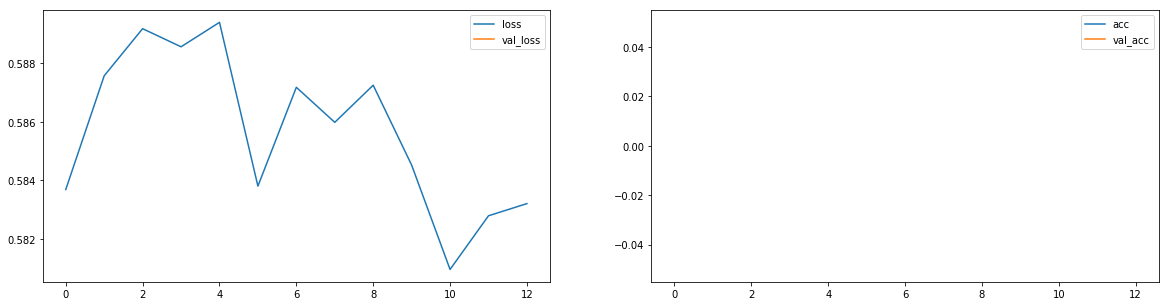

Epoch 14/500
80/82 [============================>.] - ETA: 0s - loss: 0.5838

In [ ]:
batch_size = 40
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None)
checkpointer = ModelCheckpoint(filepath='many_2_many_garcia_lorca.hdf5', verbose=1, save_best_only=True)
model.fit(all_data_input, all_data_output, batch_size=batch_size, epochs=500, verbose = 1,
                    callbacks=[checkpointer, plot_losses])

In [24]:
model.save_weights('many_2_many_4.hdf5')